<a href="https://colab.research.google.com/github/david-oruna/pneumonia-classification/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de neumonía en rayos X pediátricos de SCI

Este proyecto consiste en entrenar una CNN (Red Neuronal Convolusional) para detectar pacientes con pneumonia utilizando una dataset de Rayos X pediátricos. Utilizaremos técnicas de preprocesamiento (aumentación y normalización) y luego aplicaremos transfer learning con ResNet50.

Nos basamos en el tutorial de transfer learning de tensorflow:
https://www.tensorflow.org/tutorials/images/transfer_learning



# Preprocesamiento
## 1. Preparando el dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/keys/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle competitions download -c sci-pediatric-chest-x-ray-pneumonia-classificatio


100% 1.14G/1.14G [01:04<00:00, 22.8MB/s]
100% 1.14G/1.14G [01:04<00:00, 18.9MB/s]


In [10]:
! unzip -q "sci-pediatric-chest-x-ray-pneumonia-classificatio.zip"

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras


In [47]:
train_dir = '/content/train/train'


In [57]:

img_height = 224
img_width = 224
batch_size = 32

# Aumento de data
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

# Creamos training dataset con aumento
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


# Testing dataset (sin aumento)
val_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Aplicamos prefetch para asegurar que la data preprocesada este disponible para entrenar el modelo
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3816 files belonging to 2 classes.
Using 3053 files for training.
Found 3816 files belonging to 2 classes.
Using 763 files for validation.


Image shape: (32, 224, 224, 3)
Label shape: (32, 1)
Image data type: <dtype: 'float32'>
Label data type: <dtype: 'float32'>


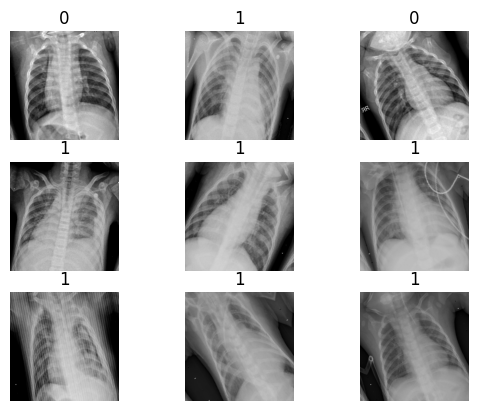

In [56]:
import matplotlib.pyplot as plt

# Mostramos algunas radiografías
for images, labels in train_ds.take(1):  # primer batch

    print("Image shape:", images.shape)
    print("Label shape:", labels.shape)
    print("Image data type:", images.dtype)
    print("Label data type:", labels.dtype)

    images = images.numpy()  # Desnormalizamos para plot

    for i in range(9):  # 9 radiografías
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(int(labels[i]))  # (0 - Normal, 1 - Pneumonia)
        plt.axis("off")
    plt.show()

# Transfer Learning

Ahora que ya tenemos la dataset lista (preprocesada, aumentada y dividida en training y validation), vamos a entrenar el modelo CNN utilizando la técnica Transfer Learning.

En esta ocasión usaremos ResNet50, un conocido y excelente CNN de clasificación de imágenes, que ha mostrado buenos resultados en tareas relacionadas a imagenes médicas, incluyendo clasificación de radiografías toráxicas. (1)

## 1. Feature Extraction

In [50]:

# Cargamos el modelo. No se incluye la capa top o de salida pues es la capa de clasificación que agregaremos para el output deseado.

base_model = keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3)
)


# Congelamos para que no se actualizen los pesos de las capas de ResNet durante el entrenamiento
# Esto significa que utilizaremos el modelo para extraer características del dataset (Feature Extraction)

base_model.trainable = False

# Un ojo a ResNet
base_model.summary()


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [51]:

# Agregamos capa de clasificación personalizada
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)


x.shape

#(n de imagenes por batch, h, w, features)

(None, 7, 7, 2048)

In [52]:
x = keras.layers.GlobalAveragePooling2D()(x) # Promediar los mapas de características en las 2 dimensiones (7x7 en este caso), resultando en un solo valor por cada canal de características dentro de cada mapa (Vectorizar)
x.shape
# La forma es (None (Debido a que el numero de imagenes por batch puede variar), y 2048 (pues es el numero de características que produce Resnet por imagen))

(None, 2048)

In [53]:

outputs = keras.layers.Dense(1, activation='sigmoid')(x) # Resultado binario
model = keras.Model(inputs, outputs)
base_learning_rate = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate = base_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

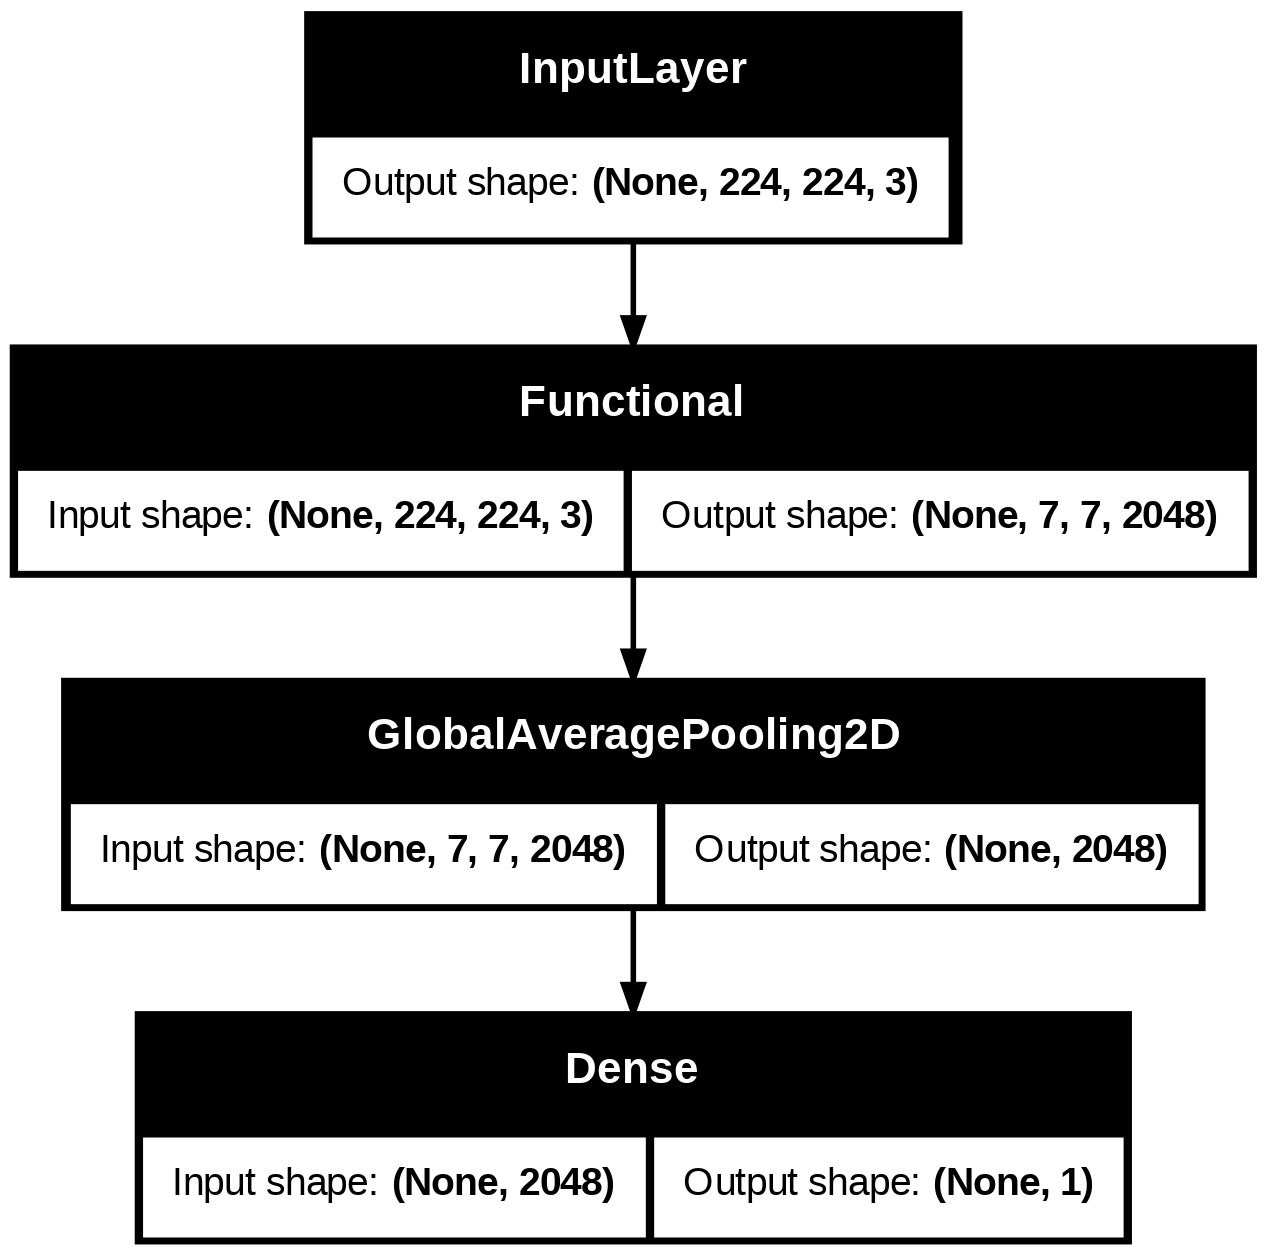

In [43]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [58]:

# Y a quemar la PC!
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 62s 531ms/step - accuracy: 0.7185 - loss: 0.5992 - val_accuracy: 0.4063 - val_loss: 0.8518
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 70s 435ms/step - accuracy: 0.7263 - loss: 0.5845 - val_accuracy: 0.1599 - val_loss: 1.1970
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 431ms/step - accuracy: 0.7319 - loss: 0.5772 - val_accuracy: 0.0498 - val_loss: 1.5635
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 431ms/step - accuracy: 0.7225 - loss: 0.5838 - val_accuracy: 0.0039 - val_loss: 2.0253
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 420ms/step - accuracy: 0.7224 - loss: 0.5817 - val_accuracy: 0.0000e+00 - val_loss: 2.5286
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 43s 441ms/step - accuracy: 0.7225 - loss: 0.5791 - val_accuracy: 0.0000e+00 - val_loss: 3.1119
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 428ms/step - accuracy: 0.7288 - loss: 0.5714 - val_accuracy: 0.0000e+00 - val_loss: 3.6384
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 450ms/step - accuracy: 0.7236 - loss: 0.574

In [59]:
loss, accuracy = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.0000e+00 - loss: 5.3453
initial loss: 5.42
initial accuracy: 0.00


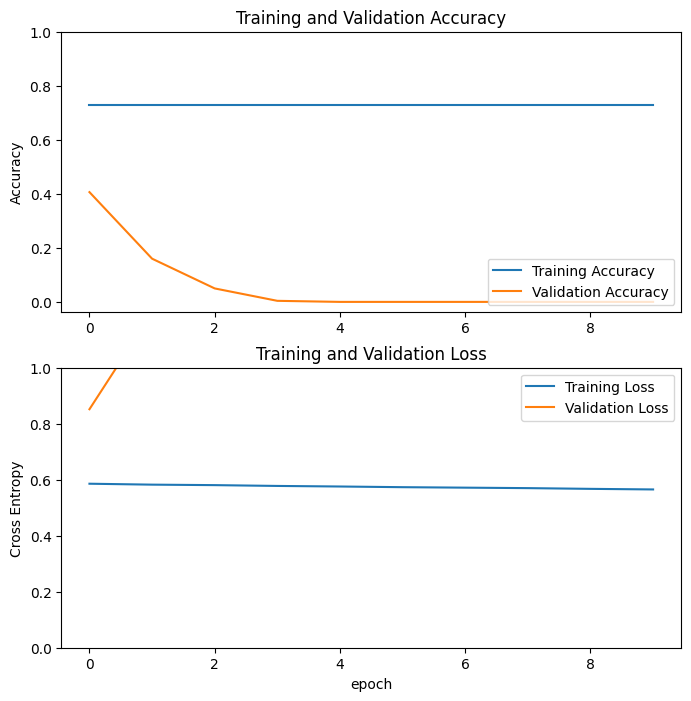

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Referencias

1. Osman Güler, Kemal Polat (2022). Neural Network Learning of Context-Dependent Affordances. Journal of Artificial Intelligence and Systems, 4, 107–106. https://doi.org/10.33969/AIS.2022040107.

